In [1]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython import display

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

from gala.dynamics import mockstream as ms

from scipy.interpolate import InterpolatedUnivariateSpline
import imf

In [2]:
mw = gp.load('/mnt/home/apricewhelan/projects/gaia-actions/potentials/MilkyWayPotential2022.yml')
H = gp.Hamiltonian(mw, frame=gp.StaticFrame(galactic))

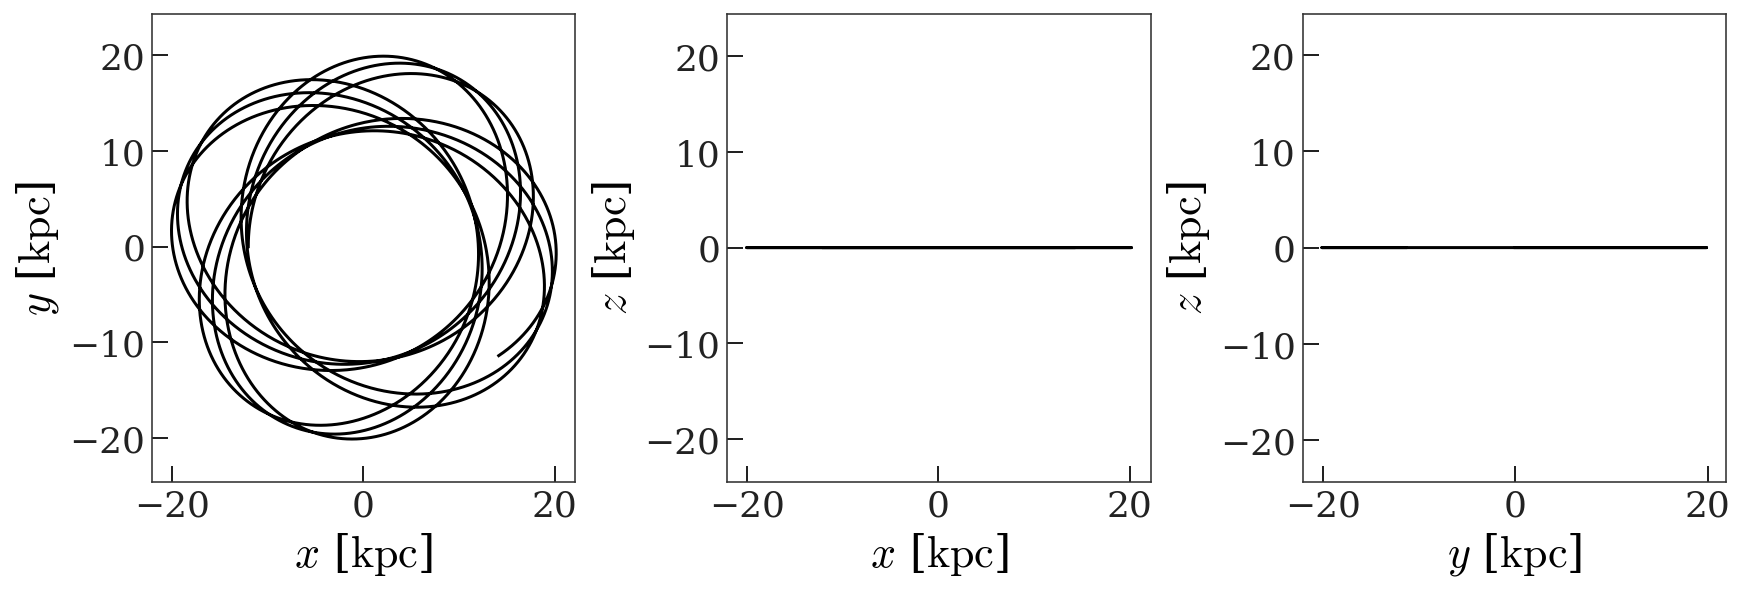

In [3]:
w0 = gd.PhaseSpacePosition(
    pos=[-12, 0., 0.] * u.kpc,
    vel=[0, 275, 0] * u.km/u.s
)
orbit = mw.integrate_orbit(w0, dt=1., t1=0, t2=4*u.Gyr)
orbit.plot();

### Parameters

In [4]:
M_stream = 5e4 * u.Msun

M_subhalo = 5e6 * u.Msun
c_subhalo = 1.005 * u.kpc * (M_subhalo / (1e8*u.Msun))**0.5 / 4.  # 1-sigma
subhalo_v = 50 * u.pc/u.Myr
impact_par = c_subhalo

t_buffer_impact = np.round((100*u.pc / subhalo_v).to(u.Myr), decimals=1)
impact_dt = np.round((1*u.pc / subhalo_v).to(u.Myr), decimals=2)

c_subhalo.to(u.pc)

<Quantity 56.18120793 pc>

In [5]:
t_pre_impact = 3 * u.Gyr
t_after_impact = 250 * u.Myr
stream_dt = 0.2 * u.Myr
release_every = 1
n_particles = 4
seed = 42

In [6]:
movie_dt = 1 * u.Myr

First, run the stream to know where stars end up in unperturbed case:

In [7]:
rng = np.random.default_rng(seed=seed)
df = ms.FardalStreamDF(random_state=rng)
gen = ms.MockStreamGenerator(df=df, hamiltonian=H)
stream, prog_w = gen.run(
    w0,
    M_stream,
    dt=stream_dt,
    t1=0,
    t2=t_pre_impact,
    release_every=release_every,
    n_particles=1,
    progress=True,
)

Integrating orbits:  100%

In [8]:
stream_style = dict(marker='o', ms=1., ls='none', alpha=0.2, plot_function=plt.plot)

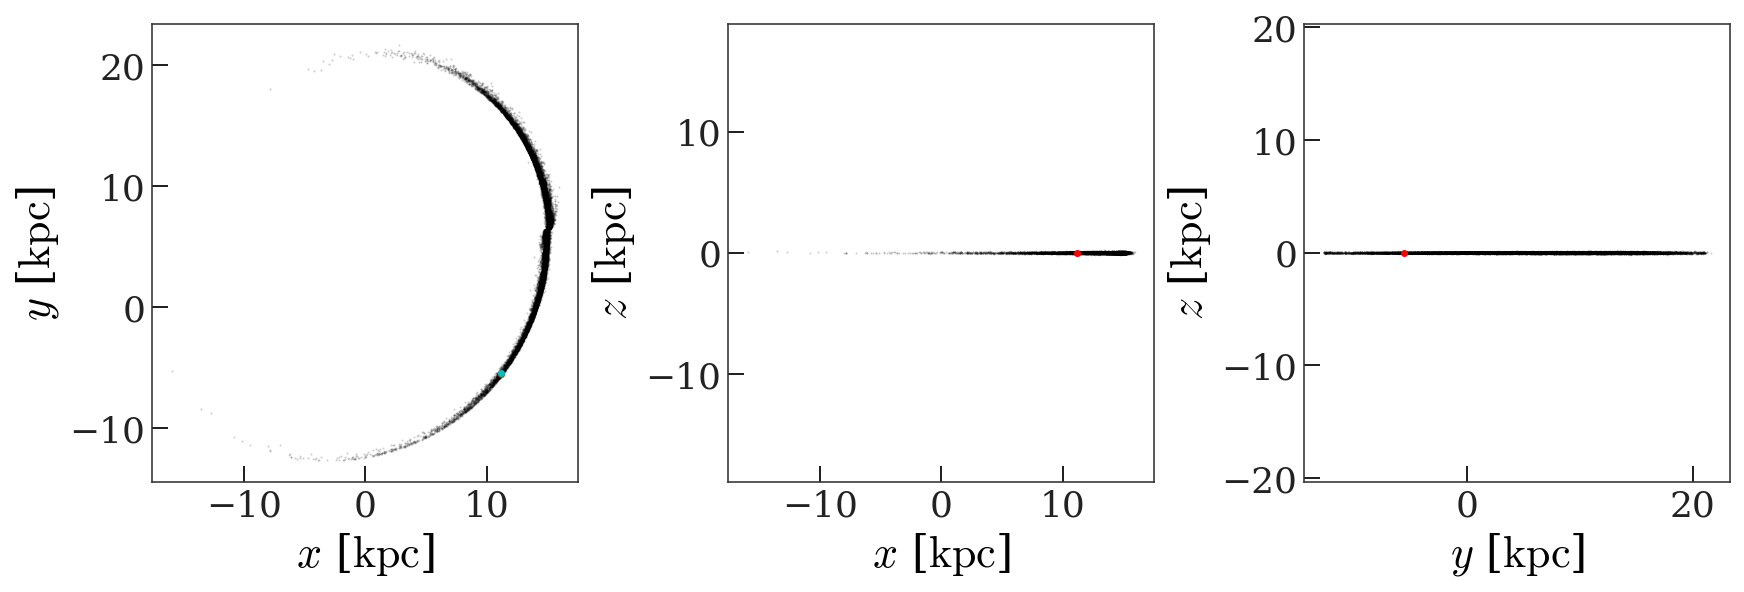

In [35]:
rng = np.random.default_rng(seed=42)
fig = stream.plot(**stream_style)
rando_star_idx = rng.integers(stream.shape[0])
rando_star = stream[rando_star_idx]
rando_star.plot(color='r', axes=fig.axes, autolim=False, zorder=100)

d_stream = np.linalg.norm(stream.xyz - rando_star.xyz[:, None], axis=0)
w_impact = gd.PhaseSpacePosition(
    np.mean(stream.xyz[:, d_stream < 1*u.kpc], axis=1),
    np.mean(stream.v_xyz[:, d_stream < 1*u.kpc], axis=1)
)
w_impact.plot(['x', 'y'], color='c', axes=fig.axes, autolim=False, zorder=100);

In [36]:
dv_dir = np.array([1, 0, 0.])
# dv_dir = rng.normal(size=3)
dv_dir /= np.linalg.norm(dv_dir)

dx_dir = np.array([1., 0, 0.])
# dx_dir = rng.normal(size=3)
# dx_dir /= np.linalg.norm(dx_dir)

w_subhalo_impact = gd.PhaseSpacePosition(
    pos=w_impact.xyz + dx_dir * impact_par,
    vel=w_impact.v_xyz + dv_dir * subhalo_v,
)
w_subhalo_buffer = H.integrate_orbit(
    w_subhalo_impact,
    dt=-stream_dt / 10,
    t1=0,
    t2=-t_buffer_impact,
    Integrator=gi.Ruth4Integrator,
    store_all=False,
)[0]

In [37]:
rng = np.random.default_rng(seed=seed)
df = ms.FardalStreamDF(random_state=rng)
gen = ms.MockStreamGenerator(df=df, hamiltonian=H)
stream_buffer_pre, prog_w_buffer_pre = gen.run(
    w0,
    M_stream,
    dt=stream_dt,
    t1=0,
    t2=t_pre_impact - t_buffer_impact,
    release_every=release_every,
    n_particles=n_particles,
    progress=False
)

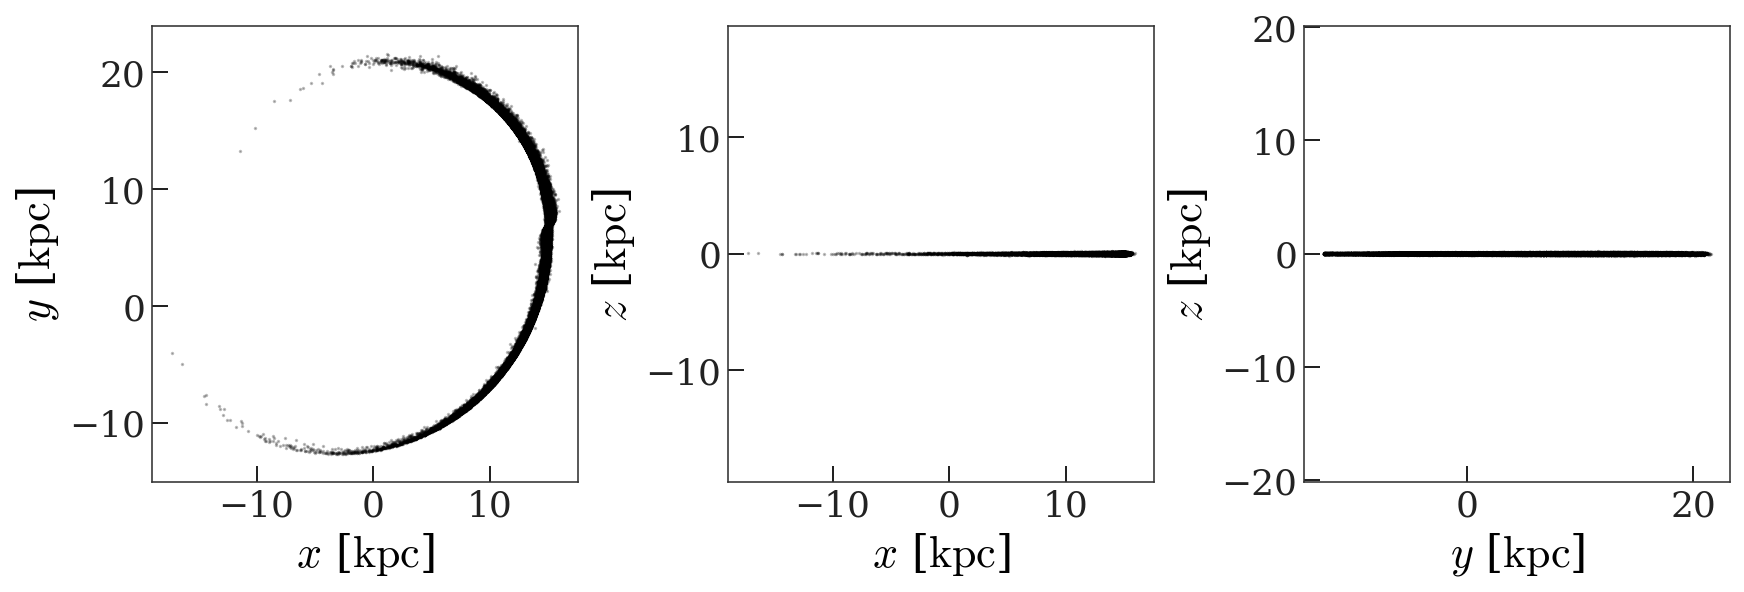

In [38]:
stream_buffer_pre.plot(s=2., alpha=0.25);

In [39]:
tmp = gd.PhaseSpacePosition(
    stream_buffer_pre.pos, stream_buffer_pre.vel, frame=stream_buffer_pre.frame
)
nbody_w0 = gd.combine((w_subhalo_buffer, tmp))

null_potential = gp.NullPotential(units=galactic)
nbody = gd.DirectNBody(
    w0=nbody_w0,
    particle_potentials=[
        gp.HernquistPotential(m=M_subhalo, c=c_subhalo, units=galactic)
    ]
    + [null_potential] * tmp.shape[0],
    external_potential=H.potential,
    frame=H.frame,
    save_all=True,
)
stream_impact = nbody.integrate_orbit(
    dt=impact_dt, t1=t_pre_impact - t_buffer_impact, t2=t_pre_impact + t_buffer_impact
)

In [40]:
tmp = mw.integrate_orbit(
    w_subhalo_buffer,
    dt=-stream_dt,
    t1=t_pre_impact - t_buffer_impact,
    t2=0,
    Integrator=gi.Ruth4Integrator,
)

subhalo_orbit = mw.integrate_orbit(
    tmp[-1],
    dt=stream_dt,
    t1=0.,
    t2=t_pre_impact + t_after_impact,
    Integrator=gi.Ruth4Integrator,
)
mask = np.isclose(subhalo_orbit.t % movie_dt, 0)
subhalo_orbit_movie = subhalo_orbit[mask]

In [ ]:
stream_after_impact = mw.integrate_orbit(
    stream_impact[-1],
    dt=stream_dt,
    t1=t_pre_impact + t_buffer_impact,
    t2=t_pre_impact + t_after_impact,
    Integrator=gi.Ruth4Integrator,
    store_all=True
)

In [ ]:
unpert_stream_post, _ = gen.run(
    prog_w_buffer_pre[0],
    M_stream,
    dt=stream_dt,
    t1=t_pre_impact - t_buffer_impact,
    t2=t_pre_impact + t_after_impact,
    release_every=release_every,
    n_particles=n_particles,
    progress=False,
#     output_every=1, 
#     output_filename='../cache/tmp-stream-post.hdf5',
#     overwrite=True
)

In [ ]:
w_impact_end = H.integrate_orbit(w_impact, dt=0.5*u.Myr, t1=0, t2=t_after_impact);

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
kw = dict(components=['x', 'y'], axes=[ax])
fig = stream_after_impact[-1].plot(**stream_style, **kw)
# unpert_stream_post.plot(**stream_style, zorder=100, **kw);
w_impact_end[-1].plot(color='tab:red', autolim=False, zorder=100, **kw);

In [46]:
end_stream = stream_after_impact[-1]
end_stream.shape[0]

119929

### Stellar population

In [47]:
iso = at.Table.read('/mnt/home/apricewhelan/data/isochrones/mist/FeH_-1.8_iso.fits')
iso = iso[np.isclose(iso['log10_isochrone_age_yr'], 10.)]

In [48]:
imf_masses = imf.make_cluster(M_stream.value) # , mmax=iso['initial_mass'].max())

imf_mask = imf_masses < iso['initial_mass'].max()
imf_masses = imf_masses[imf_mask]
imf_masses = rng.choice(imf_masses, size=end_stream.shape[0], replace=True)

imf_masses.sum(), len(imf_masses)

Total cluster mass is 49999.6 (limit was 50000)


(24523.461765479733, 119929)

In [49]:
interp_mass2eep = InterpolatedUnivariateSpline(iso["initial_mass"], iso["EEP"], k=1)
imf_eeps = interp_mass2eep(imf_masses)

eep2mag_interps = {}
for mag in ["g", "r", "i"]:
    eep2mag_interps[mag] = InterpolatedUnivariateSpline(
        iso["EEP"], iso[f"ps1_{mag}"], k=1
    )

In [50]:
phot = at.Table() 
for k, func in eep2mag_interps.items():
    phot[f"M_{k}"] = func(imf_eeps)

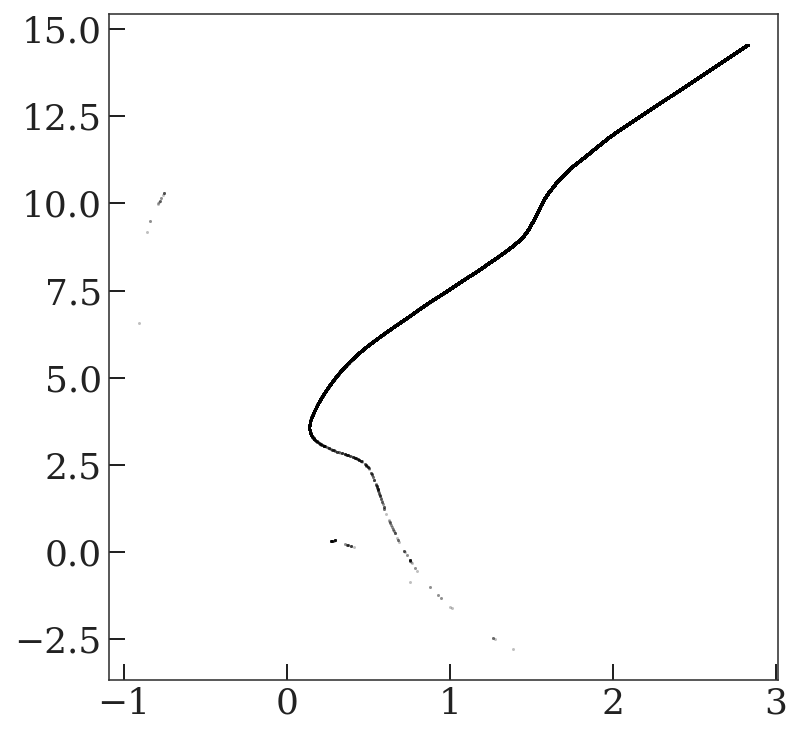

In [51]:
plt.plot(
    phot['M_g'] - phot['M_i'],
    phot['M_r'],
    marker='o', ls='none', ms=1.5, alpha=0.25
)

In [52]:
stream_galcen = coord.Galactocentric(end_stream.data)
stream_gal = stream_galcen.transform_to(coord.Galactic())

perturb_end_galcen = coord.Galactocentric(w_impact_end[-1].data)
perturb_end_gal = perturb_end_galcen.transform_to(coord.Galactic())

stream_frame = coord.SkyOffsetFrame(origin=perturb_end_gal)

stream_sfr = stream_gal.transform_to(stream_frame)

In [53]:
for k in eep2mag_interps.keys():
    phot[k] = phot[f"M_{k}"] + stream_gal.distance.distmod.value

(30.0, 12.0)

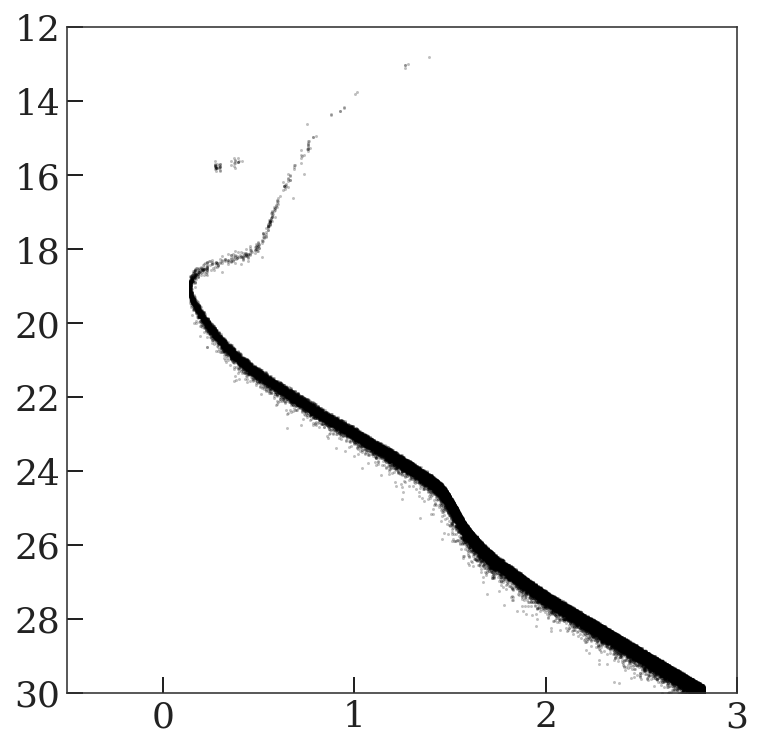

In [54]:
plt.plot(
    phot['g'] - phot['i'],
    phot['r'],
    marker='o', ls='none', ms=1.5, alpha=0.25
)
plt.xlim(-0.5, 3)
plt.ylim(30, 12)

(-5.0, 5.0)

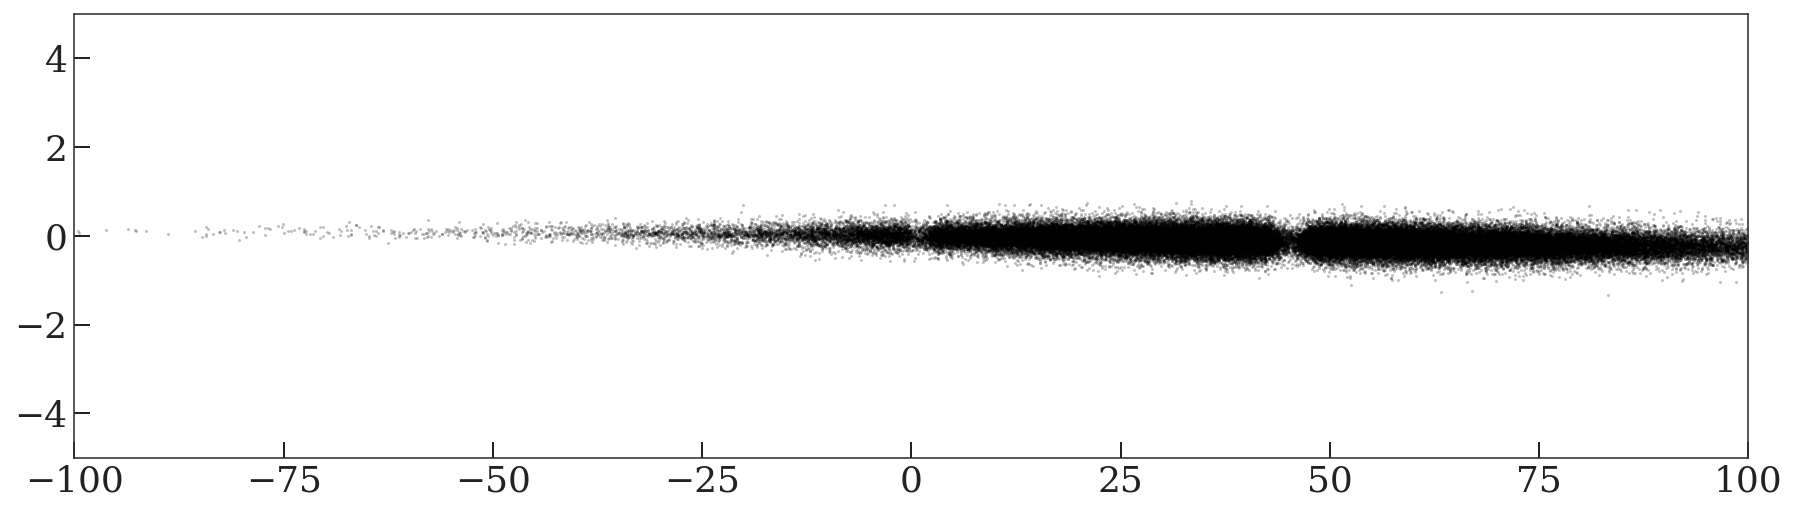

In [55]:
plt.figure(figsize=(15, 4))
plt.plot(
    #stream_gal.l.wrap_at(180*u.deg).degree,
    #stream_gal.b.degree,
    stream_sfr.lon.wrap_at(180*u.deg).degree,
    stream_sfr.lat.degree,
    marker='o',
    ls='none',
    ms=1.5,
    alpha=0.25
)
plt.xlim(-100, 100)
plt.ylim(-5, 5)

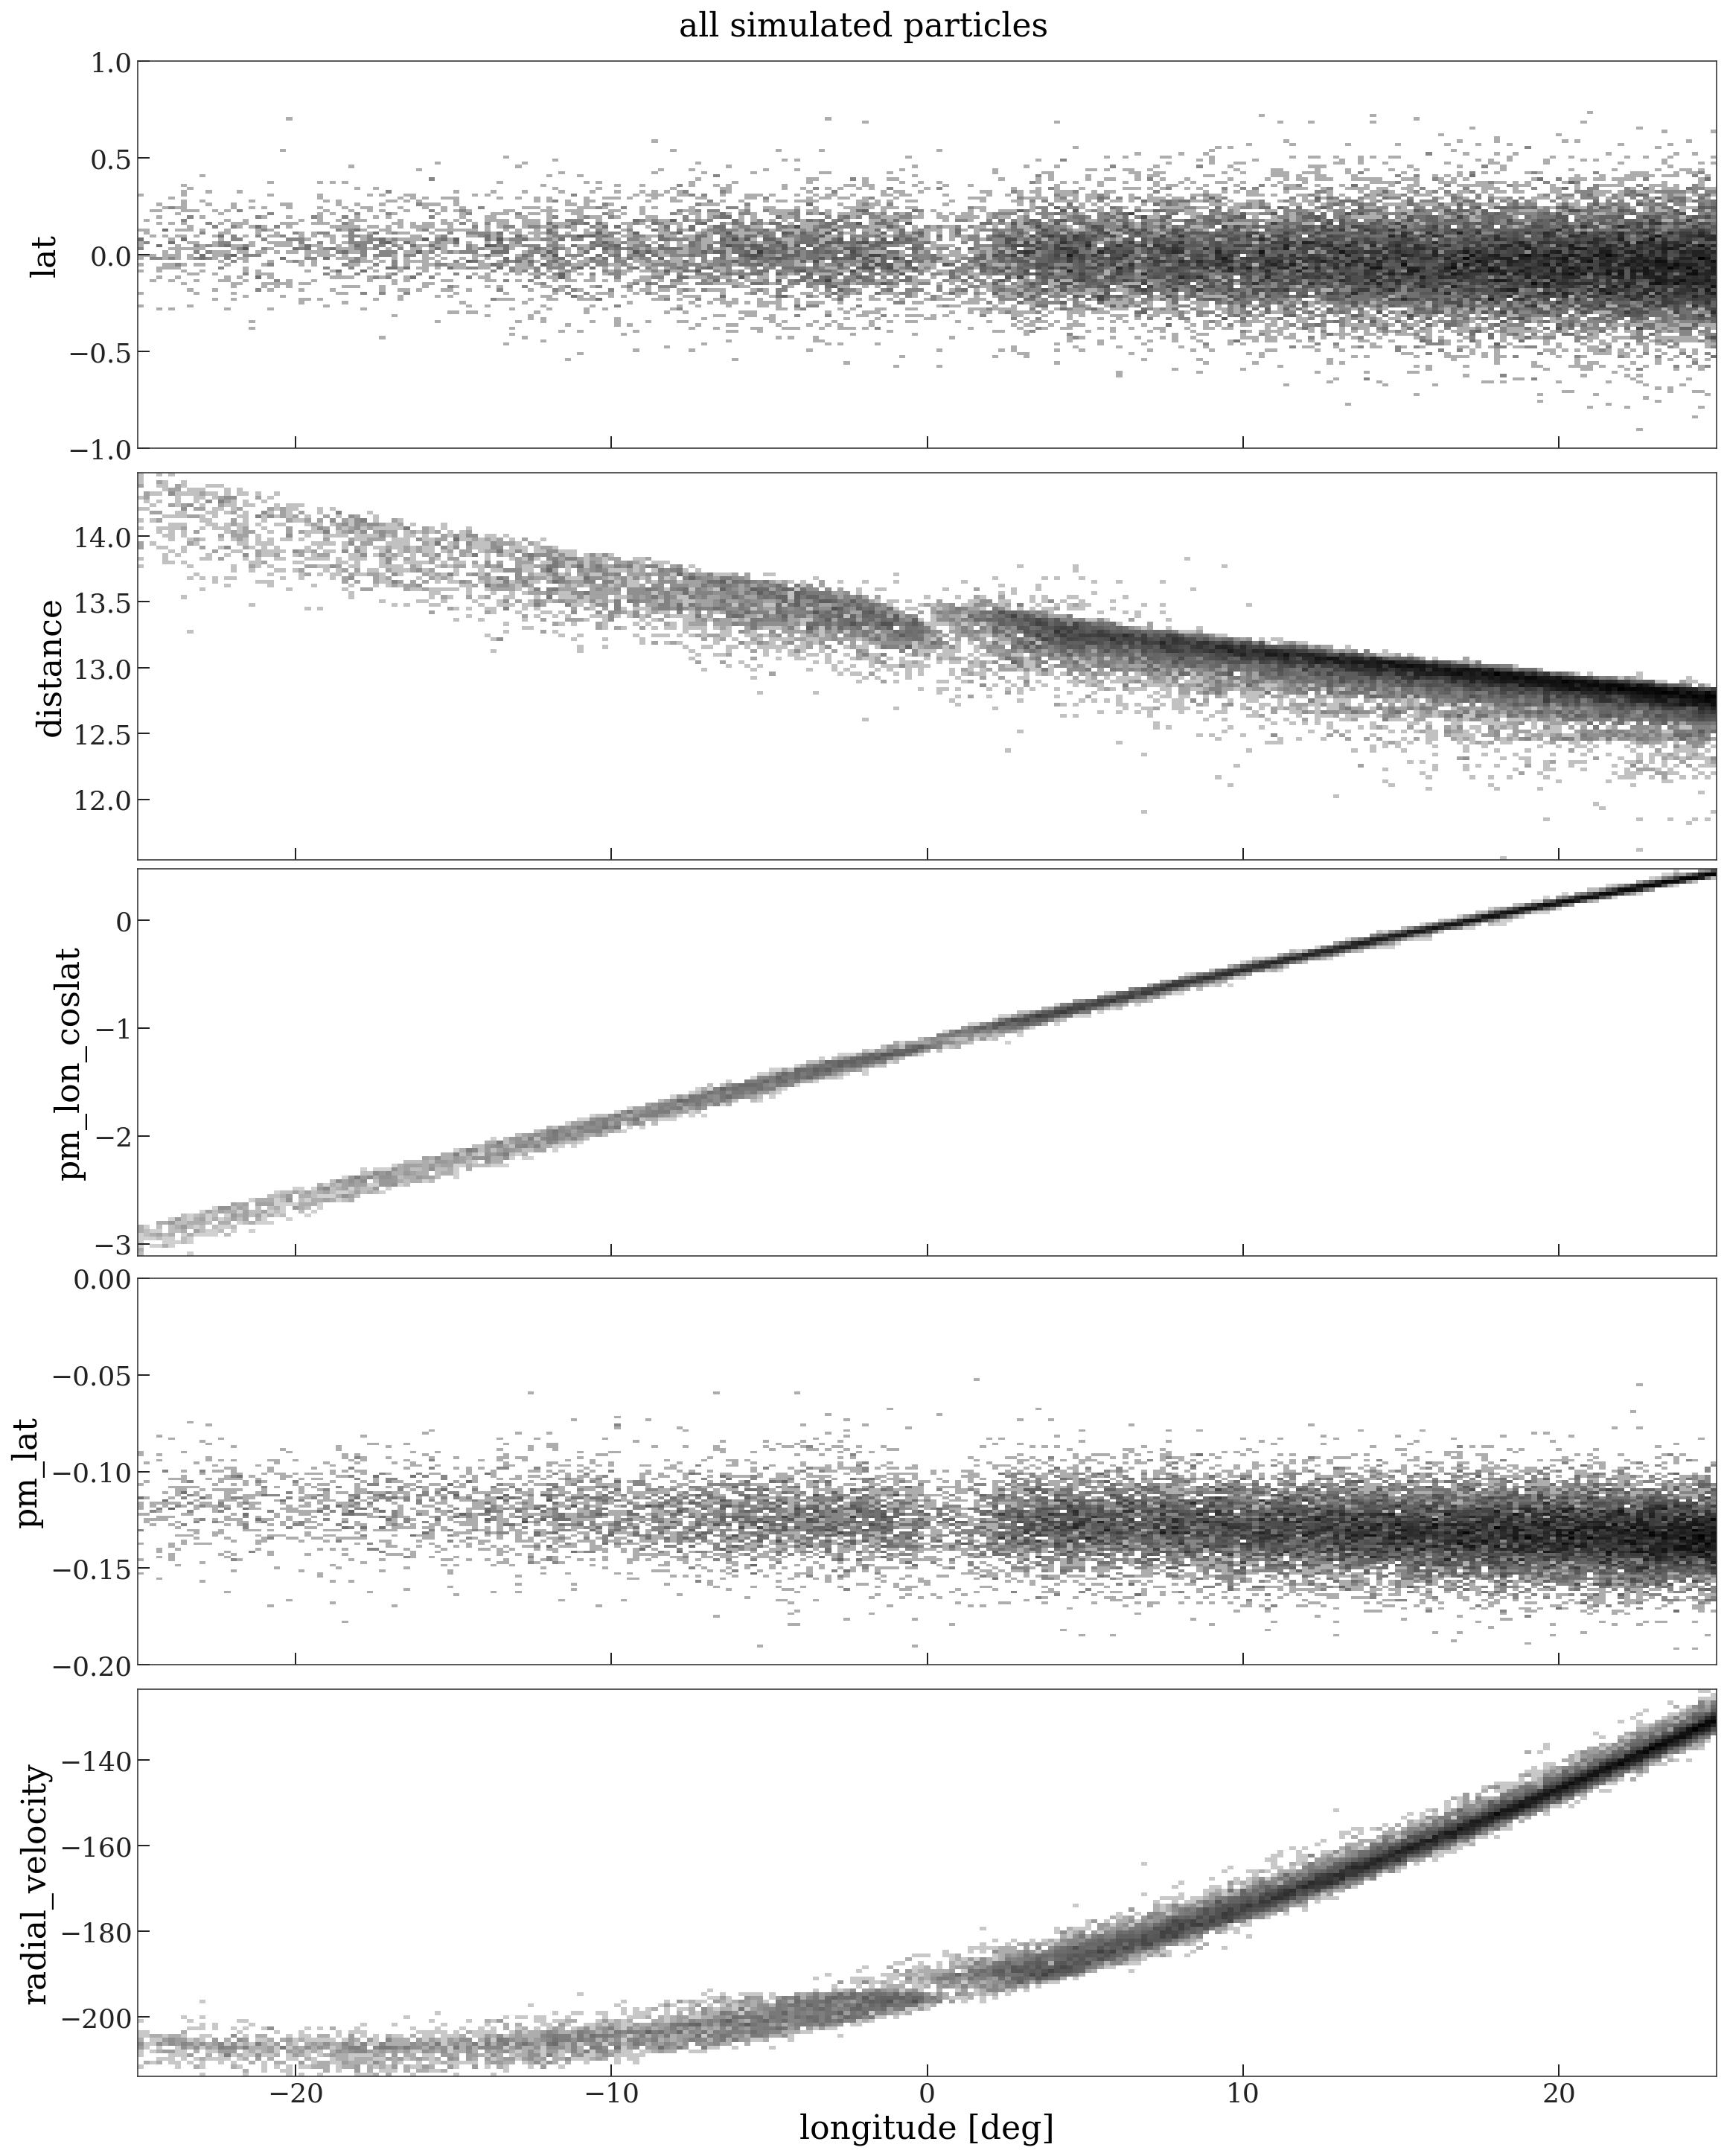

In [56]:
xlim = (-25, 25)
lon = stream_sfr.lon.wrap_at(180 * u.deg).degree
_mask = (lon > xlim[0]) & (lon < xlim[1])

# ---

fig, axes = plt.subplots(5, 1, figsize=(16, 20), sharex=True, constrained_layout=True)

ax = axes[0]

comps = ["lat", "distance", "pm_lon_coslat", "pm_lat", "radial_velocity"]
lims = [(-1, 1), None, None, (-0.2, 0), None]
for ax, comp, lim in zip(axes, comps, lims):
    ax.hist2d(
        lon[_mask],
        getattr(stream_sfr, comp).value[_mask],
        bins=(np.linspace(*xlim, 256), 101),
        norm=mpl.colors.LogNorm(vmin=0.1),
        cmap="Greys",
    )
    if lim is not None:
        ax.set_ylim(lim)

    ax.set_ylabel(comp)

axes[-1].set(xlim=xlim, xlabel="longitude [deg]")

fig.suptitle("all simulated particles", fontsize=22);

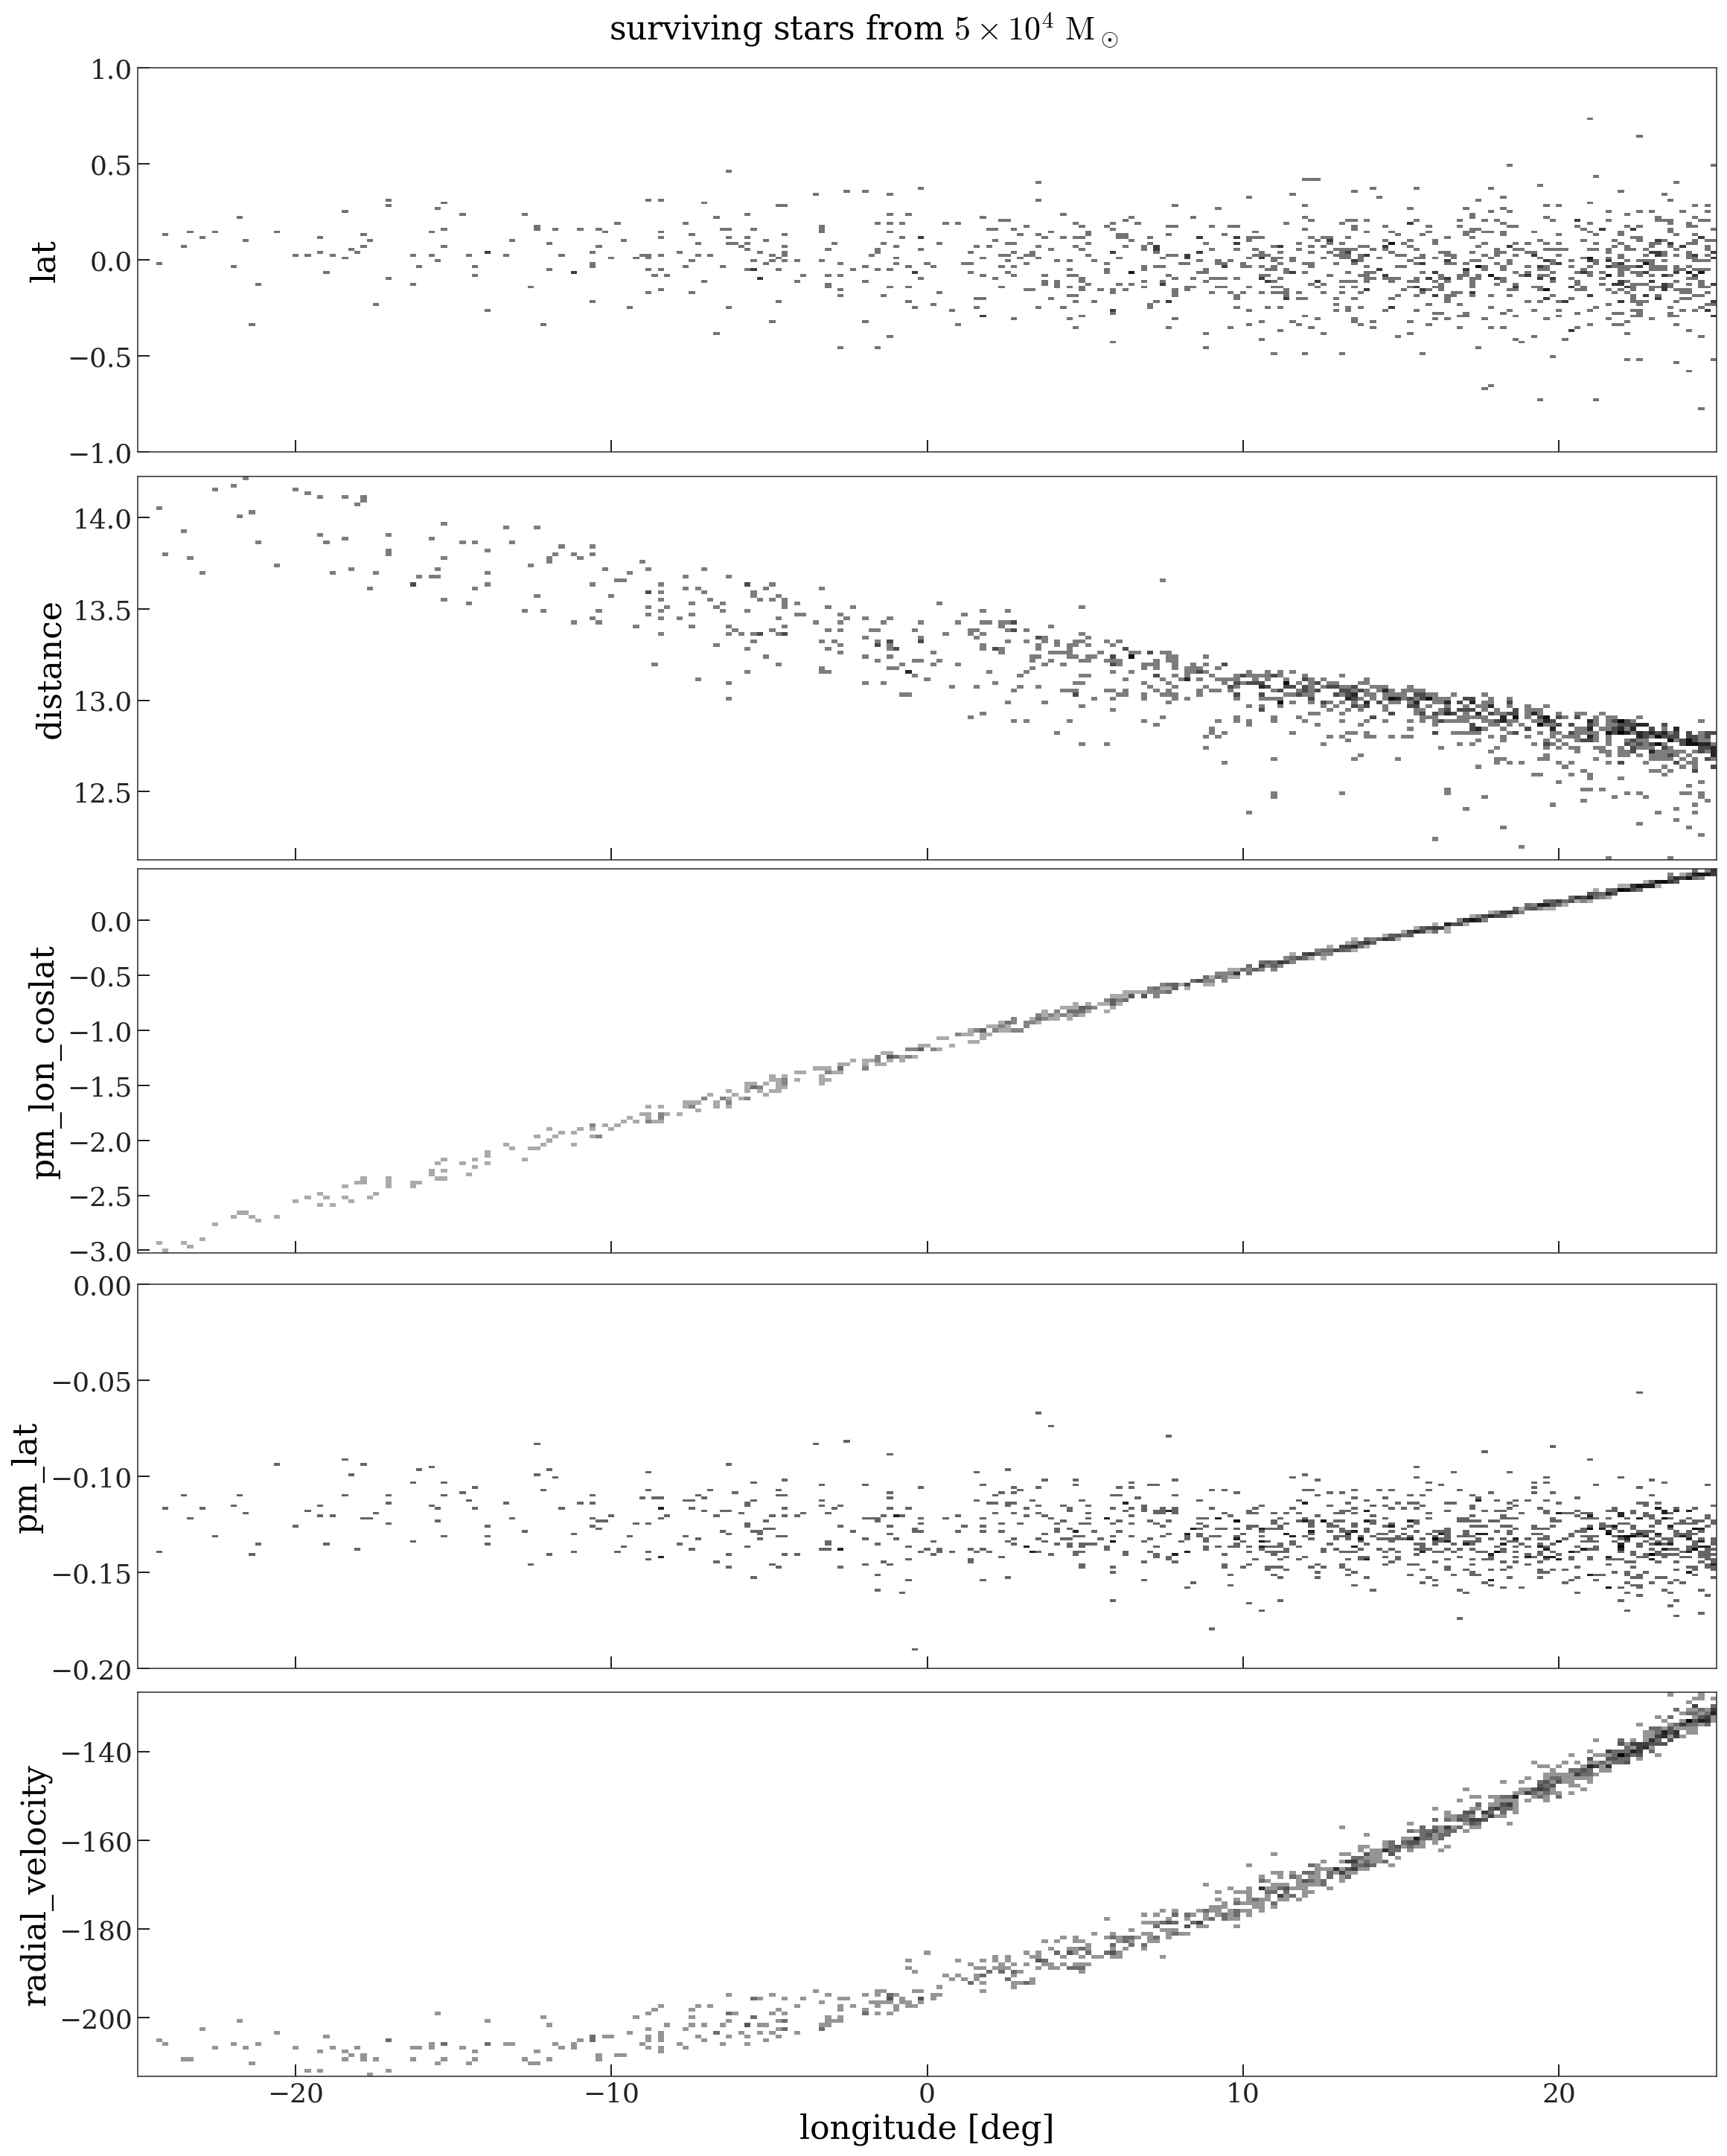

In [57]:
_mask = (
    (lon > xlim[0]) & (lon < xlim[1]) & (phot['g'] < 22)
)

# ---

fig, axes = plt.subplots(5, 1, figsize=(16, 20), sharex=True, constrained_layout=True)

ax = axes[0]

comps = ["lat", "distance", "pm_lon_coslat", "pm_lat", "radial_velocity"]
lims = [(-1, 1), None, None, (-0.2, 0), None]
for ax, comp, lim in zip(axes, comps, lims):
    ax.hist2d(
        lon[_mask],
        getattr(stream_sfr, comp).value[_mask],
        bins=(np.linspace(*xlim, 256), 101),
        norm=mpl.colors.LogNorm(vmin=0.1),
        cmap="Greys",
    )
    if lim is not None:
        ax.set_ylim(lim)

    ax.set_ylabel(comp)

axes[-1].set(xlim=xlim, xlabel="longitude [deg]")

fig.suptitle(r"surviving stars from $5\times 10^4~{\rm M}_\odot$", fontsize=22);